# Part 1

In the first part of this assignment, two deep learning models will be trained and evaluated to predict the genre of movies given their descriptions in text. These models will include a vanilla RNN and an LSTM. Afterward, the movies' titles will be added to the training data to see if that results in a boost in performance. The data set comes from https://www.kaggle.com/datasets/PromptCloudHQ/imdb-data

## Preprocessing

In [86]:
import pandas as pd
import numpy as np
import kagglehub
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
import os
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN
from sklearn.metrics import precision_score, recall_score

In [78]:
# Import files

path = kagglehub.dataset_download("PromptCloudHQ/imdb-data")
print("Path to dataset files:", path)
files = os.listdir(path)
print("Files in dataset directory:", files)
csv_file_path = os.path.join(path, 'IMDB-Movie-Data.csv')

data = pd.read_csv(csv_file_path)
print(data.columns)
data.shape

Path to dataset files: /kaggle/input/imdb-data
Files in dataset directory: ['IMDB-Movie-Data.csv']
Index(['Rank', 'Title', 'Genre', 'Description', 'Director', 'Actors', 'Year',
       'Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)',
       'Metascore'],
      dtype='object')


(1000, 12)

In [81]:
# Filter out stop words and lemmatize data

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if isinstance(text, str):
        tokens = nltk.word_tokenize(text.lower())
        filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token.isalnum()]
        return ' '.join(filtered_tokens)
    return "" # Return empty string for non-string inputs


# Apply preprocessing to 'Description' and 'Title' columns
data['Description'] = data['Description'].apply(preprocess_text)
data['Title'] = data['Title'].apply(preprocess_text)

# Combine Title and Description for potential performance boost (this is used in the 'expanded model' section).
data['text'] = data['Title'] + ' ' + data['Description']

display(data[['Title', 'Description', 'text']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,Title,Description,text
0,guardian galaxy,group intergalactic criminal forced work toget...,guardian galaxy group intergalactic criminal f...
1,prometheus,following clue origin mankind team find struct...,prometheus following clue origin mankind team ...
2,split,three girl kidnapped man diagnosed 23 distinct...,split three girl kidnapped man diagnosed 23 di...
3,sing,city humanoid animal hustling theater impresar...,sing city humanoid animal hustling theater imp...
4,suicide squad,secret government agency recruit dangerous inc...,suicide squad secret government agency recruit...


In [82]:
# Download Glove embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-07-22 20:48:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-07-22 20:48:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-07-22 20:48:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [83]:
# Process glove embeddings into a dictionary

embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [84]:
# Split data into training, test, and validation sets

# Split data into training (700) and temp (300)
train_data, temp_data = train_test_split(data, train_size=700, random_state=42)

# Split temp into validation (100) and test (200)
val_data, test_data = train_test_split(temp_data, test_size=200, random_state=42)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(700, 13)
(100, 13)
(200, 13)


In [87]:
# Tokenize data and pad data

tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(data["Description"])

X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["Description"]), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["Description"]), maxlen=200)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_data["Description"]), maxlen=200)

# Define target variables

Y_train = train_data["Genre"]
Y_test = test_data["Genre"]
Y_val = val_data["Genre"]

In [88]:
# One-hot encode target variables

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# Split the 'Genre' string by comma and apply MultiLabelBinarizer
Y_train_encoded = mlb.fit_transform(Y_train.str.split(','))
Y_test_encoded = mlb.transform(Y_test.str.split(','))
Y_val_encoded = mlb.transform(Y_val.str.split(','))

print("Shape of Y_train_encoded_mlb:", Y_train_encoded.shape)
print("Shape of Y_test_encoded_mlb:", Y_test_encoded.shape)
print("Classes (unique genres):", mlb.classes_)

Y_train_encoded

Shape of Y_train_encoded_mlb: (700, 20)
Shape of Y_test_encoded_mlb: (200, 20)
Classes (unique genres): ['Action' 'Adventure' 'Animation' 'Biography' 'Comedy' 'Crime' 'Drama'
 'Family' 'Fantasy' 'History' 'Horror' 'Music' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Sport' 'Thriller' 'War' 'Western']


array([[0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [89]:
# Create embedding matrix

word_index = tokenizer.word_index
vocab_size = min(10000, len(word_index) + 1)  # Use min with tokenizer's num_words and actual vocab size
embedding_dim = 100

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

print("Shape of embedding matrix:", embedding_matrix.shape)

Shape of embedding matrix: (5149, 100)


## Model Training

In [90]:
# LSTM Model

LSTM_model = Sequential()
LSTM_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False))
LSTM_model.add(LSTM(64, dropout=0.2, recurrent_dropout = 0.2))
LSTM_model.add(Dense(20, activation = "sigmoid"))

LSTM_model.compile(optimizer = "adam", loss="binary_crossentropy", metrics=["accuracy"])

LSTM_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       514,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,900 (1.96 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 514,900 (1.96 MB)

In [91]:
# Train LSTM Model

LSTM_history = LSTM_model.fit(X_train, Y_train_encoded,
                              epochs = 20,
                              batch_size = 64,
                              validation_data=(X_val, Y_val_encoded))

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 487ms/step - accuracy: 0.0433 - loss: 0.6613 - val_accuracy: 0.0800 - val_loss: 0.5364
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 449ms/step - accuracy: 0.1301 - loss: 0.5009 - val_accuracy: 0.1900 - val_loss: 0.3986
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 414ms/step - accuracy: 0.1733 - loss: 0.3747 - val_accuracy: 0.1900 - val_loss: 0.3419
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 447ms/step - accuracy: 0.1833 - loss: 0.3277 - val_accuracy: 0.1900 - val_loss: 0.3268
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 434ms/step - accuracy: 0.1918 - loss: 0.3150 - val_accuracy: 0.2000 - val_loss: 0.3232
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 436ms/step - accuracy: 0.1937 - loss: 0.3103 - val_accuracy: 0.2000 - val_loss: 0.3207
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 441ms/step - accuracy: 0.1926 - loss: 0.3084 - val_accuracy: 0.2000 - val_loss: 0.3173
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 415ms/step - accuracy: 0.1848 - loss: 0.3083 - val_accuracy: 0

In [92]:
LSTM_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │       514,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 645,522 (2.46 MB)

 Trainable params: 43,540 (170.08 KB)

 Non-trainable params: 514,900 (1.96 MB)

 Optimizer params: 87,082 (340.17 KB)

In [93]:
# RNN Model

RNN_model = Sequential()
RNN_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False))
RNN_model.add(SimpleRNN(64, dropout=0.2, recurrent_dropout = 0.2))
RNN_model.add(Dense(20, activation = "sigmoid"))

RNN_model.compile(optimizer = "adam", loss="binary_crossentropy", metrics=["accuracy"])

RNN_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │       514,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,900 (1.96 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 514,900 (1.96 MB)

In [94]:
# Train RNN Model

RNN_history = RNN_model.fit(X_train, Y_train_encoded,
                            epochs = 20,
                            batch_size = 64,
                            validation_data=(X_val, Y_val_encoded))

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - accuracy: 0.0295 - loss: 0.7284 - val_accuracy: 0.0300 - val_loss: 0.5530
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0866 - loss: 0.5321 - val_accuracy: 0.1500 - val_loss: 0.4035
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1612 - loss: 0.3884 - val_accuracy: 0.1900 - val_loss: 0.3492
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1902 - loss: 0.3365 - val_accuracy: 0.2100 - val_loss: 0.3341
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1913 - loss: 0.3265 - val_accuracy: 0.2000 - val_loss: 0.3287
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2013 - loss: 0.3202 - val_accuracy: 0.1900 - val_loss: 0.3268
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1920 - loss: 0.3185 - val_accuracy: 0.2000 - val_loss: 0.3256
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1858 - loss: 0.3116 - val_accuracy: 0.1900 - 

In [95]:
RNN_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 100)       │       514,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 550,482 (2.10 MB)

 Trainable params: 11,860 (46.33 KB)

 Non-trainable params: 514,900 (1.96 MB)

 Optimizer params: 23,722 (92.67 KB)

## Model Evaluation

In [96]:
# Evaluate Models on Test Set

import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
import pandas as pd

# Evaluate the RNN model
print("Evaluating RNN model on the test set...")
rnn_loss, rnn_accuracy = RNN_model.evaluate(X_test, Y_test_encoded.astype(np.float32), verbose=0)
rnn_predictions = (RNN_model.predict(X_test) > 0.5).astype(int)
rnn_precision = precision_score(Y_test_encoded, rnn_predictions, average='micro')
rnn_recall = recall_score(Y_test_encoded, rnn_predictions, average='micro')


# Evaluate the LSTM model
print("\nEvaluating LSTM model on the test set...")
lstm_loss, lstm_accuracy = LSTM_model.evaluate(X_test, Y_test_encoded.astype(np.float32), verbose=0)
lstm_predictions = (LSTM_model.predict(X_test) > 0.5).astype(int)
lstm_precision = precision_score(Y_test_encoded, lstm_predictions, average='micro')
lstm_recall = recall_score(Y_test_encoded, lstm_predictions, average='micro')

# Create a table to show the results
evaluation_data = {
    'Metric': ['Loss', 'Accuracy', 'Precision', 'Recall'],
    'RNN': [rnn_loss, rnn_accuracy, rnn_precision, rnn_recall],
    'LSTM': [lstm_loss, lstm_accuracy, lstm_precision, lstm_recall]
}

evaluation_table = pd.DataFrame(evaluation_data)

print("\nModel Evaluation Results on Test Set:")
display(evaluation_table)

Evaluating RNN model on the test set...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step

Evaluating LSTM model on the test set...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step

Model Evaluation Results on Test Set:


,Metric,RNN,LSTM
0,Loss,0.324088,0.294955
1,Accuracy,0.210000,0.425000
2,Precision,0.605634,0.638767
3,Recall,0.083012,0.279923


As can be seen from the table above, the LSTM performs better than the vanilla RNN in every metric, including loss, accuracy, precision, and recall, suggesting that the LSTM's memory leads to a significant increase in performance. The LSTM model achieves around 10% higher test accuracy than its vanilla counterpart.

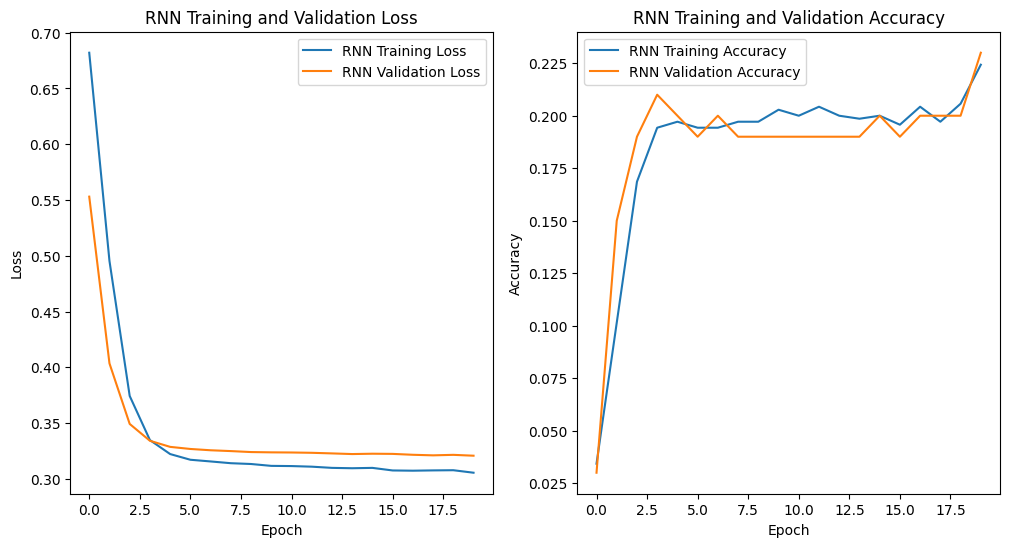

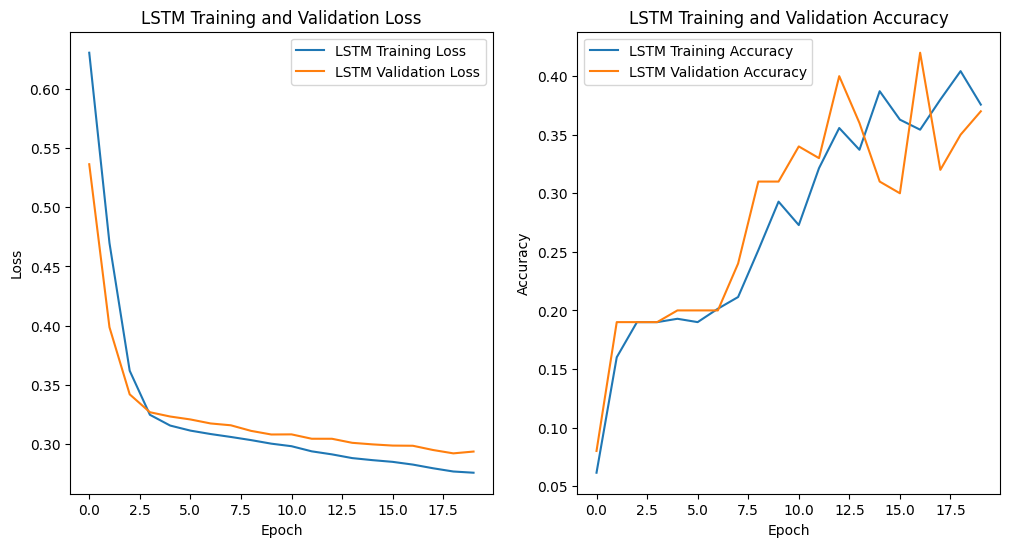

In [97]:
# Plot Evaluation Metrics

# Plot training and validation loss for RNN
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(RNN_history.history['loss'], label='RNN Training Loss')
plt.plot(RNN_history.history['val_loss'], label='RNN Validation Loss')
plt.title('RNN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy for RNN
plt.subplot(1, 2, 2)
plt.plot(RNN_history.history['accuracy'], label='RNN Training Accuracy')
plt.plot(RNN_history.history['val_accuracy'], label='RNN Validation Accuracy')
plt.title('RNN Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss for LSTM
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(LSTM_history.history['loss'], label='LSTM Training Loss')
plt.plot(LSTM_history.history['val_loss'], label='LSTM Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy for LSTM
plt.subplot(1, 2, 2)
plt.plot(LSTM_history.history['accuracy'], label='LSTM Training Accuracy')
plt.plot(LSTM_history.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.title('LSTM Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

As we can see from the plots above, the RNN rapidly reduced its loss and then plateued. The LSTM, on the other hand, rapidly decreased its loss and then kept decreasing it at a slower rate. This continued steep rate of decline suggests that greater accuracy and lower loss could be achieved from a greater number of training epochs.

Overall, we can conclude that the LSTM is far better suited for this task, achieving an accuracy of around 10% higher than the vanilla RNN. For this reason, we will continue by testing the LSTM's performance when using each movie's title as well as description, as opposed to just the description.

## Expanded Dataset

In [98]:
# Tokenize and prepare expanded data (the 'text' column)

tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(data["text"])

X_train_expanded = pad_sequences(tokenizer.texts_to_sequences(train_data["text"]), maxlen=200)
X_test_expanded = pad_sequences(tokenizer.texts_to_sequences(test_data["text"]), maxlen=200)

X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["text"]), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["text"]), maxlen=200)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_data["text"]), maxlen=200)

In [99]:
# Create new embedding matrix

word_index = tokenizer.word_index
vocab_size = min(10000, len(word_index) + 1)  # Use min with tokenizer's num_words and actual vocab size
embedding_dim = 100

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

print("Shape of embedding matrix:", embedding_matrix.shape)

Shape of embedding matrix: (5649, 100)


In [100]:
# Define new LSTM model

LSTM_model_expanded = Sequential()
LSTM_model_expanded.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False))
LSTM_model_expanded.add(LSTM(64, dropout=0.2, recurrent_dropout = 0.2))
LSTM_model_expanded.add(Dense(20, activation = "sigmoid"))

LSTM_model_expanded.compile(optimizer = "adam", loss="binary_crossentropy", metrics=["accuracy"])

In [104]:
# Train LSTM Model (use same target data frame prepared earlier)
LSTM_expanded_history = LSTM_model_expanded.fit(X_train_expanded, Y_train_encoded,
                              epochs = 20,
                              batch_size = 64,
                              validation_data=(X_val, Y_val_encoded))

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 431ms/step - accuracy: 0.4091 - loss: 0.2629 - val_accuracy: 0.3600 - val_loss: 0.2805
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - accuracy: 0.3614 - loss: 0.2607 - val_accuracy: 0.3000 - val_loss: 0.2791
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 434ms/step - accuracy: 0.3488 - loss: 0.2626 - val_accuracy: 0.3200 - val_loss: 0.2796
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 417ms/step - accuracy: 0.3980 - loss: 0.2548 - val_accuracy: 0.3400 - val_loss: 0.2770
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 431ms/step - accuracy: 0.3878 - loss: 0.2560 - val_accuracy: 0.3300 - val_loss: 0.2755
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 440ms/step - accuracy: 0.4048 - loss: 0.2534 - val_accuracy: 0.3100 - val_loss: 0.2745
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - accuracy: 0.3574 - loss: 0.2560 - val_accuracy: 0.3000 - val_loss: 0.2739
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 424ms/step - accuracy: 0.4171 - loss: 0.2528 - val_accuracy: 0.

In [105]:
# Test Model
print("\nEvaluating LSTM model on the test set...")
lstm_expanded_loss, lstm_expanded_accuracy = LSTM_model_expanded.evaluate(X_test, Y_test_encoded.astype(np.float32), verbose=0)
lstm_expanded_predictions = (LSTM_model_expanded.predict(X_test) > 0.5).astype(int)
lstm_expanded_precision = precision_score(Y_test_encoded, lstm_expanded_predictions, average='micro')
lstm_expanded_recall = recall_score(Y_test_encoded, lstm_expanded_predictions, average='micro')


print("LSTM Model Evaluation Results on Test Set:")
print(f"Loss: {lstm_expanded_loss:.4f}")
print(f"Accuracy: {lstm_expanded_accuracy:4f}")
print(f"Precision: {lstm_expanded_precision:.4f}")
print(f"Recall: {lstm_expanded_recall:.4f}")


Evaluating LSTM model on the test set...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
LSTM Model Evaluation Results on Test Set:
Loss: 0.2616
Accuracy: 0.365000
Precision: 0.6655
Recall: 0.3726


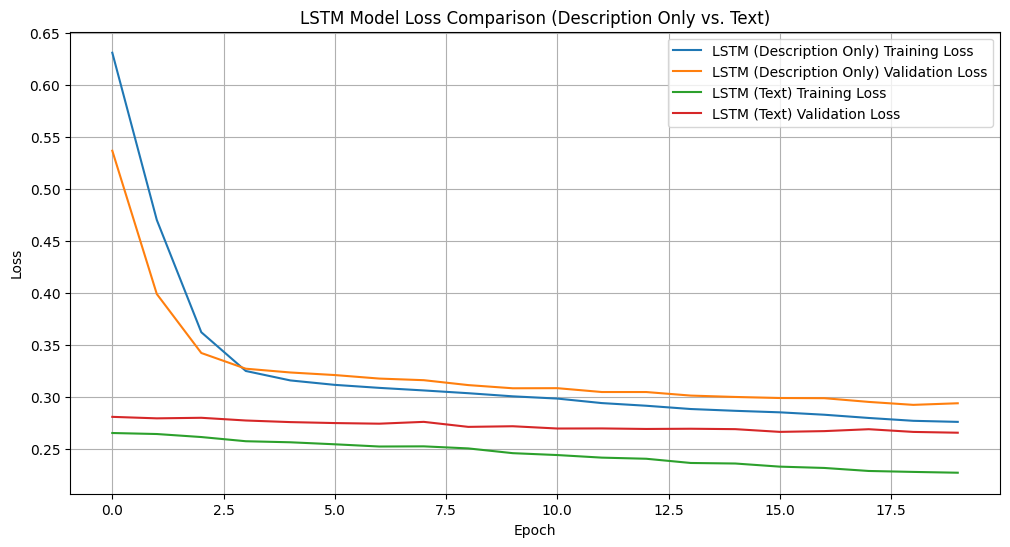

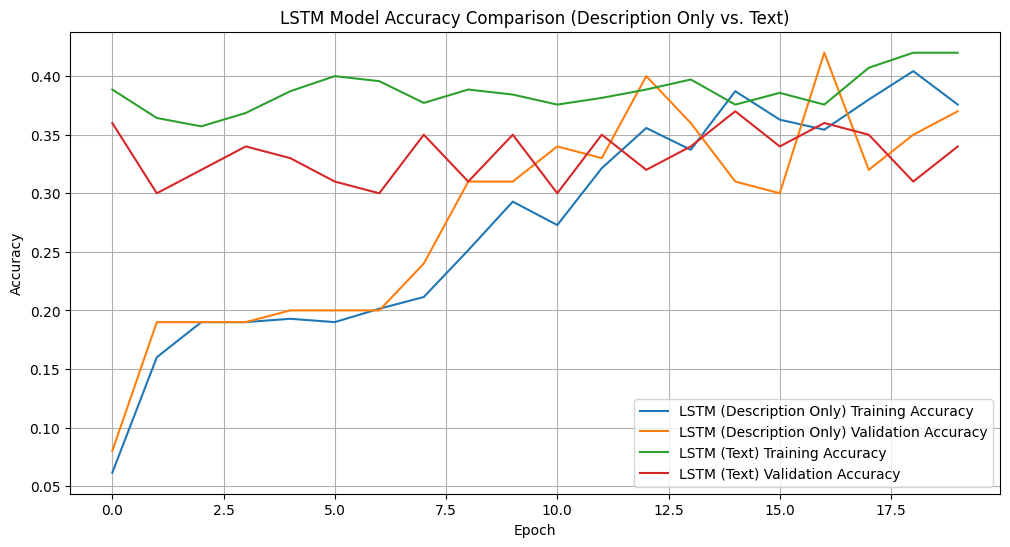

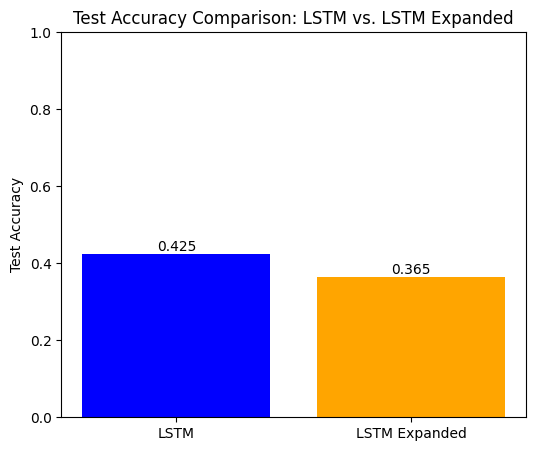

In [106]:
# Plot Loss Comparison
plt.figure(figsize=(12, 6))
plt.plot(LSTM_history.history['loss'], label='LSTM (Description Only) Training Loss')
plt.plot(LSTM_history.history['val_loss'], label='LSTM (Description Only) Validation Loss')
plt.plot(LSTM_expanded_history.history['loss'], label='LSTM (Text) Training Loss')
plt.plot(LSTM_expanded_history.history['val_loss'], label='LSTM (Text) Validation Loss')
plt.title('LSTM Model Loss Comparison (Description Only vs. Text)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Comparison
plt.figure(figsize=(12, 6))
plt.plot(LSTM_history.history['accuracy'], label='LSTM (Description Only) Training Accuracy')
plt.plot(LSTM_history.history['val_accuracy'], label='LSTM (Description Only) Validation Accuracy')
plt.plot(LSTM_expanded_history.history['accuracy'], label='LSTM (Text) Training Accuracy')
plt.plot(LSTM_expanded_history.history['val_accuracy'], label='LSTM (Text) Validation Accuracy')
plt.title('LSTM Model Accuracy Comparison (Description Only vs. Text)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Show difference in test accuracy
models = ['LSTM', 'LSTM Expanded']
test_accuracies = [lstm_accuracy, lstm_expanded_accuracy]

plt.figure(figsize=(6, 5))
bars = plt.bar(models, test_accuracies, color=['blue', 'orange'])

plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison: LSTM vs. LSTM Expanded')
plt.ylim(0, 1) # Accuracy is between 0 and 1

# Add the accuracy values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom', ha='center')

plt.show()

As can be seen from the charts above, the expanded LSTM model including movie title did not acheive a higher test accuracy than the one smaller one. From this, we cannot conclude that the title was helpful in predicting genre.

# Part 2

In this part, a CNN will be used to classify images into one of six categories: streets, buildings, woods, mountains, seas, and glaciers.

## Preprocessing

In [107]:
import cv2


path = kagglehub.dataset_download("puneet6060/intel-image-classification")
#path = "/kaggle/input/intel-image-classification"
print("Path to dataset files:", path)
files = os.listdir(path)
print("Files in dataset directory:", files)

Path to dataset files: /kaggle/input/intel-image-classification
Files in dataset directory: ['seg_train', 'seg_pred', 'seg_test']


In [108]:
train_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train"
test_dir = "/kaggle/input/intel-image-classification/seg_test/seg_test"

In [109]:
classes = os.listdir(train_dir)
print(classes)

['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


In [110]:
# Load test images and labels

test_images = []
test_labels = []

for label in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, label)
    if os.path.isdir(class_dir):  # Check if it's a directory
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    # Resize images to a consistent size if necessary
                    img = cv2.resize(img, (150, 150))
                    test_images.append(img)
                    test_labels.append(label)
                else:
                    print(f"Warning: Could not read image {img_path}")
            except Exception as e:
                print(f"Error reading image {img_path}: {e}")

print(f"Loaded {len(test_images)} test images.")
print(f"Loaded {len(test_labels)} test labels.")

# Convert lists to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

print("Shape of test_images:", test_images.shape)
print("Shape of test_labels:", test_labels.shape)

Loaded 3000 test images.
Loaded 3000 test labels.
Shape of test_images: (3000, 150, 150, 3)
Shape of test_labels: (3000,)


In [111]:
# Load training images and labels

train_images = []
train_labels = []

for label in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, label)
    if os.path.isdir(class_dir):  # Check if it's a directory
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    # Resize images to a consistent size if necessary
                    img = cv2.resize(img, (150, 150))
                    train_images.append(img)
                    train_labels.append(label)
                else:
                    print(f"Warning: Could not read image {img_path}")
            except Exception as e:
                print(f"Error reading image {img_path}: {e}")

print(f"Loaded {len(train_images)} training images.")
print(f"Loaded {len(train_labels)} training labels.")

# Convert lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

print("Shape of train_images:", train_images.shape)
print("Shape of train_labels:", train_labels.shape)

Loaded 14034 training images.
Loaded 14034 training labels.
Shape of train_images: (14034, 150, 150, 3)
Shape of train_labels: (14034,)


In [112]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Normalize image data
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# One-hot encode labels
train_labels_one_hot = to_categorical(train_labels_encoded)
test_labels_one_hot = to_categorical(test_labels_encoded)

print("Shape of normalized train_images:", train_images.shape)
print("Shape of normalized test_images:", test_images.shape)
print("Shape of one-hot encoded train_labels:", train_labels_one_hot.shape)
print("Shape of one-hot encoded test_labels:", test_labels_one_hot.shape)

Shape of normalized train_images: (14034, 150, 150, 3)
Shape of normalized test_images: (3000, 150, 150, 3)
Shape of one-hot encoded train_labels: (14034, 6)
Shape of one-hot encoded test_labels: (3000, 6)


## Model Training

In [113]:
# First model: 3 convolutional layers and 3 max pooling layers

cnn_model1 = keras.models.Sequential()
cnn_model1.add(keras.layers.Input(shape=(150, 150, 3)))
cnn_model1.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model1.add(keras.layers.MaxPooling2D((2, 2)))
cnn_model1.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model1.add(keras.layers.MaxPooling2D((2, 2)))
cnn_model1.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model1.add(keras.layers.MaxPooling2D((2, 2)))
cnn_model1.add(keras.layers.Dropout(0.5))
cnn_model1.add(keras.layers.Flatten())
cnn_model1.add(keras.layers.Dense(128, activation='relu'))
cnn_model1.add(keras.layers.Dense(6, activation='softmax'))


cnn_model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
cnn_model1.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [114]:
cnn_history1 = cnn_model1.fit(train_images, train_labels_one_hot,
                              epochs = 10,
                              batch_size = 64)

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5369 - loss: 1.1563
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7583 - loss: 0.6564
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8281 - loss: 0.4756
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8586 - loss: 0.3901
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9026 - loss: 0.2797
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9206 - loss: 0.2305
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9414 - loss: 0.1680
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9551 - loss: 0.1299
Epoch 9/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9628 - loss: 0.1089
Epoch 10/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9709 - loss: 0.0842


In [115]:
# Second model: 6 convolutional layers and 3 max pooling layers

cnn_model2 = keras.models.Sequential()
cnn_model2.add(keras.layers.Input(shape=(150, 150, 3)))
cnn_model2.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model2.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model2.add(keras.layers.MaxPooling2D((2, 2)))
cnn_model2.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model2.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model2.add(keras.layers.MaxPooling2D((2, 2)))
cnn_model2.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model2.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model2.add(keras.layers.MaxPooling2D((2, 2)))
cnn_model2.add(keras.layers.Dropout(0.5))
cnn_model2.add(keras.layers.Flatten())
cnn_model2.add(keras.layers.Dense(128, activation='relu'))
cnn_model2.add(keras.layers.Dense(6, activation='softmax'))

cnn_model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
cnn_model2.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 146, 146, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 69, 69, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,974,310 (15.16 MB)

 Trainable params: 3,974,310 (15.16 MB)

 Non-trainable params: 0 (0.00 B)

In [116]:
cnn_history2 = cnn_model2.fit(train_images, train_labels_one_hot,
                              epochs = 10,
                              batch_size = 128)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.4376 - loss: 1.3527
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6717 - loss: 0.8260
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7492 - loss: 0.6658
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7917 - loss: 0.5725
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8152 - loss: 0.5087
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8238 - loss: 0.4863
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8491 - loss: 0.4074
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8607 - loss: 0.3739
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8736 - loss: 0.3426
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8849 - loss: 0.3049


## Model Evaluation

Now that each model has been defined and trained, we can see the results of each model on the test set.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


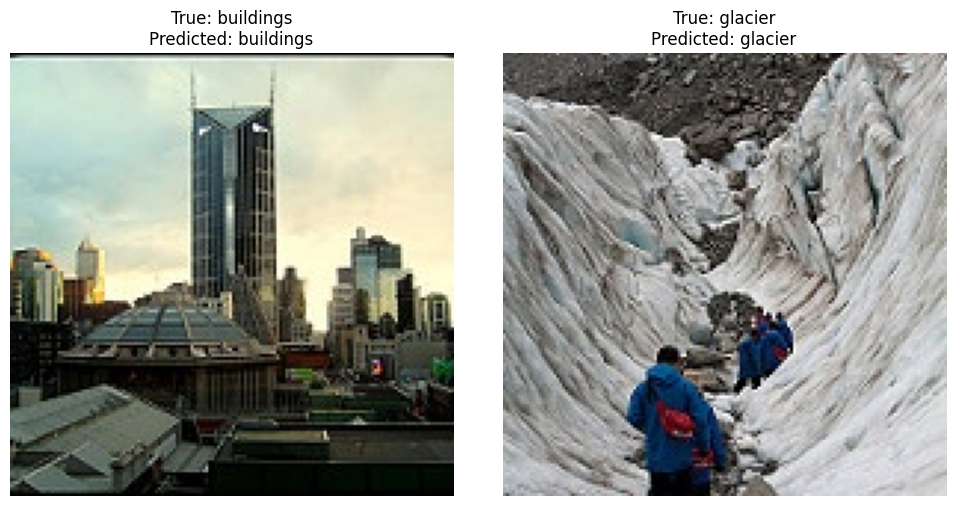

In [117]:
# Select two random samples from the test set
random_indices = np.random.choice(len(test_images), 2, replace=False)

# Get the selected images, true labels, and predicted labels
sample_images = test_images[random_indices]
sample_true_labels_encoded = np.argmax(test_labels_one_hot[random_indices], axis=1)
sample_true_labels = label_encoder.inverse_transform(sample_true_labels_encoded)

# Get predictions for the selected samples
sample_predictions_prob = cnn_model2.predict(sample_images)
sample_predicted_labels_encoded = np.argmax(sample_predictions_prob, axis=1)
sample_predicted_labels = label_encoder.inverse_transform(sample_predicted_labels_encoded)

# Turn images into RGB
sample_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in sample_images]

# Visualize the samples
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {sample_true_labels[i]}\nPredicted: {sample_predicted_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Shown above is the second model predicting two images.

In [118]:
from sklearn.metrics import classification_report

# Evaluate CNN Model 1
cnn1_predictions_prob = cnn_model1.predict(test_images)
cnn1_predictions = np.argmax(cnn1_predictions_prob, axis=1)
test_labels_original = label_encoder.inverse_transform(np.argmax(test_labels_one_hot, axis=1))
cnn1_report = classification_report(test_labels_original, label_encoder.inverse_transform(cnn1_predictions), target_names=classes, output_dict=True)

# Evaluate CNN Model 2
cnn2_predictions_prob = cnn_model2.predict(test_images)
cnn2_predictions = np.argmax(cnn2_predictions_prob, axis=1)
cnn2_report = classification_report(test_labels_original, label_encoder.inverse_transform(cnn2_predictions), target_names=classes, output_dict=True)

# Extract overall and weighted average metrics
cnn1_overall_metrics = cnn1_report['accuracy']
cnn2_overall_metrics = cnn2_report['accuracy']

cnn1_weighted_avg = cnn1_report['weighted avg']
cnn2_weighted_avg = cnn2_report['weighted avg']

# Extract per-class accuracy
cnn1_per_class_accuracy = {cls: cnn1_report[cls]['recall'] for cls in classes} # Recall is equivalent to per-class accuracy in this context
cnn2_per_class_accuracy = {cls: cnn2_report[cls]['recall'] for cls in classes}

# Prepare data for the table
evaluation_data_cnn = {
    'Metric': ['Accuracy', 'Weighted Avg Precision', 'Weighted Avg Recall', 'Weighted Avg F1-score'] + [f'{cls} Accuracy' for cls in classes],
    'CNN Model 1': [cnn1_overall_metrics, cnn1_weighted_avg['precision'], cnn1_weighted_avg['recall'], cnn1_weighted_avg['f1-score']] + [cnn1_per_class_accuracy[cls] for cls in classes],
    'CNN Model 2': [cnn2_overall_metrics, cnn2_weighted_avg['precision'], cnn2_weighted_avg['recall'], cnn2_weighted_avg['f1-score']] + [cnn2_per_class_accuracy[cls] for cls in classes]
}

evaluation_table_cnn = pd.DataFrame(evaluation_data_cnn)

print("CNN Model Comparison on Test Set:")
display(evaluation_table_cnn)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
CNN Model Comparison on Test Set:


,Metric,CNN Model 1,CNN Model 2
0,Accuracy,0.802333,0.831000
1,Weighted Avg Precision,0.812861,0.834282
2,Weighted Avg Recall,0.802333,0.831000
3,Weighted Avg F1-score,0.802353,0.831190
4,mountain Accuracy,0.883295,0.864989
5,street Accuracy,0.873418,0.919831
6,buildings Accuracy,0.759494,0.732369
7,sea Accuracy,0.655238,0.819048
8,forest Accuracy,0.880392,0.835294
9,glacier Accuracy,0.786427,0.834331


Shown above is the classification report for each model, including accuracy, precision, recall, F1-score, and per-class accuracy. The second model with more convultion layers consistently outperforms the first model with fewer layers, except for the classification of mountains, buildings, and forests. The high amount of training accuracy present in the first model suggests that it may be overfitting.

The relatively high (83%) accuracy of the second model suggests that it is highly suited for this image classification task.